# Sensitivity Analysis and Data Assimilation on the example of Lorenz and SEIR models

Today's tutorial will be divided into three parts:

1. Introduction to Lorenz and SEIR models
1. Sensitivity analysis
1. Data assimilation with 4DVar

# Introduction to Lorenz and SEIR models



### Lorenz

![Lorenz equations](images/lorenz.png)

source: https://en.wikipedia.org/wiki/Lorenz_system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

Method that computes one timestep of Lorenz model:

In [2]:
def lorenz_step(state, _, rho, sigma, beta):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

Let's draw the model's trajectory for the basic parameters:

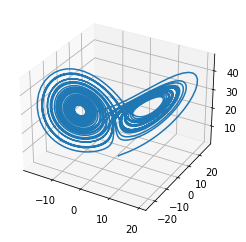

In [3]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

state0 = [1,1,1]

t = np.arange(0.0, 40.0, 0.01)

states = odeint(lorenz_step, state0, t, args=(rho,sigma,beta))

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

### SEIR

![SEIR epidemic model](images/seir.png)

SEIR is a model that simulates an outbreak of a virus.

The population is divided into four groups:
* S - group of humans **susceptible** to be exposed to the virus. Before an epidemic starts, all population members belong to this group.
* E - group of people that were **exposed** to the virus. In this stage they already started to develop the illness, but they don't show symptoms nor infect others yet.
* I - group of **infectious** individuals, who can pass the virus to susceptible members.
* R - people that have already **recovered** from the infection.

Additionaly we can specify two more groups:
* D - a group of individuals that are **dead** as a result of the infection
* N - total number of alive individuals

---

There are four parameters. The reasonable bounds for them are given in the brackets:
* alfa - the case fatality rate - fraction of Infected group that dies each day. [0.001, 0.01]
* beta - probability of disease transmission times the number of contacts per day. [0, 7]
* epsilon - rate of progression from Exposed to Infectious (so 1/eps is the incubation period). [0.05, 0.5] (from 2 to 20 days)
* gamma - rate of progression from Infectious to Recovered (so 1/gamma is the length of the infectious period) [0.05, 0.5] (from 2 to 20 days)


---

These are the equations which represent the group size in the following time step:

S = S - S \* beta \* I / N  
E = E + S \* beta \* I / N - eps \* E  
I = I + eps \* E - (alfa + gamma) \* I  
R = R + gamma \* I  
D = alfa \* I  


In [4]:
def seir_step(state):
    state = list(np.ravel(state))
    state = list(map(lambda x : max(x, 0), state))
    S_old, E_old, I_old, R_old, D_old, alfa, beta, eps, gamma = state

    N = S_old + E_old + I_old + R_old
    D = D_old + alfa * I_old
    S = S_old - S_old * beta * I_old / N
    E = E_old + S_old * beta * I_old / N - eps * E_old
    I = I_old + eps * E_old - (alfa + gamma) * I_old
    R = R_old + gamma * I_old

    results = [S, E, I, R, D, alfa, beta, eps, gamma]
    return np.array(results).reshape(-1, 1)

Let's simulate a sample epidemic

**TASK 1** Choose some values from the reasonable bounds introduced earlier and observe the effect on the plots



Susceptible, exposed, infectious, recovered and dead individuals


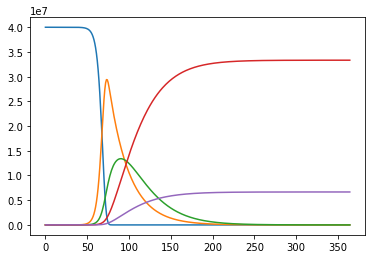

In [5]:
# TODO: insert values for alfa, beta, eps, gamma
params = [ 0.008, 3, 0.04, 0.04 ]
seird = [40000000, 1, 0, 0, 0]
state = np.array(seird + params).reshape(-1, 1)

days = 365

states = np.empty((days,5))
for i in range(days):
    states[i]  = state[:5][:,0]
    state = seir_step(state)

plt.plot( range(days),states[:,0])
plt.plot( range(days),states[:,1])
plt.plot( range(days),states[:,2])
plt.plot( range(days),states[:,3])
plt.plot( range(days),states[:,4])
print('Susceptible, exposed, infectious, recovered and dead individuals')

Exposed, infectious and dead individuals


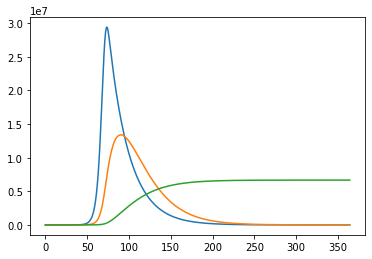

In [6]:
plt.plot( range(days),states[:,1])
plt.plot( range(days),states[:,2])
plt.plot( range(days),states[:,4])
print('Exposed, infectious and dead individuals')

# Sensitivity analysis

In order to check which parameters of the model have the biggest influence on the output, we can perform a Sensitivity Analysis. SALib is a Python library that implements it. It does two things:


1.   Generates a set of inputs to be fed to the model
2.   Analyses outputs returned by the model for this set of inputs


In [7]:
from SALib.sample import saltelli
from SALib.analyze import sobol

### Sensitivity analysis - Lorenz 63 model

We will perform SA on Lorenz 63 model. First, we need to define the parameters of the model and generate a set of input parameters.

In [8]:
problem = {
    'num_vars': 3,
    'names': ['rho', 'sigma', 'beta'],
    'bounds': [[14.0,42.0],
               [3.0, 20.0],
               [7.0/3.0, 9.0/3.0]]
}

#Let's generate 20 values for each parameter:
input = saltelli.sample(problem, 20)

print(input.shape)
print(input[:5])

(160, 3)
[[20.15234375  4.64355469  2.67903646]
 [32.94921875  4.64355469  2.67903646]
 [20.15234375  7.76464844  2.67903646]
 [20.15234375  4.64355469  2.93815104]
 [20.15234375  7.76464844  2.93815104]]


Now, we need to define our model and generate an output value for each input (each set of parameters)

Lorenz model has a 3-dimensional state (x,y,z) for each timestep. However, SA can only analyse a single output for a given input.

In order to deal with that, we will analyse the sensitivity in the 3 dimensions separately. We will analyse the standard deviation of values in each dimension.

In [9]:
def generate_outputs_lorenz(parameter_combinations):
    # We need an output array with a row for each generated input and 3 colums for 3 output variables (x, y, z)
    output = np.empty( shape=(parameter_combinations.shape[0],3) )
    # Define timesteps for Lorenz 63 integration
    t = np.arange(0.0, 40.0, 0.01)

    for i, params in enumerate(parameter_combinations):
        initial_state = [1,1,1]
        rho, sigma, beta = params[0], params[1], params[2]

        # Get states in each timestep:
        states = odeint(lorenz_step, initial_state, t, args=(rho, sigma, beta))

        # We take the standard deviation in each dimension as the output.
        output[i] = np.std(states, axis=0)
    return output

output = generate_outputs_lorenz(input)

Finally, we can analyse the sensitivity. We analyse it in respect to each output dimension separately

In [10]:
Si_X = sobol.analyze(problem, output[:,0], print_to_console=False)['S1']
Si_Y = sobol.analyze(problem, output[:,1], print_to_console=False)['S1']
Si_Z = sobol.analyze(problem, output[:,2], print_to_console=False)['S1']

print('           ', list(map(lambda name: name + ' '*(5-len(name)),    problem['names'])))
print('X analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si_X)))
print('Y analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si_Y)))
print('Z analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si_Z)))

            ['rho  ', 'sigma', 'beta ']
X analysis: ['1.046', '0.181', '0.105']
Y analysis: ['0.991', '0.166', '0.059']
Z analysis: ['0.969', '0.065', '0.045']


The higher the value, the more the parameter affects the behaviour of the model.
The rho parameter influences all dimensions of model significantly.

### Sensitivity analysis - SEIR model

Now we will perform a similar SA on the SEIR model

**TASK 2** Just like in the Lorenz example, define the number of variables, their names and the bounds. Use the bounds provided in the definition of the model

In [11]:
problem_seir = {
    'num_vars': 4 ,
    'names': ['alfa', 'beta', 'eps', 'gamma'] ,
    'bounds': [[0.001, 0.01],
               [0, 7],
               [0.05, 0.5],
               [0.05, 0.5]]
}

input = saltelli.sample(problem_seir, 100)

print(input.shape)
print(input[:5])

(1000, 4)
[[2.97753906e-03 6.76757812e-01 2.83349609e-01 3.54541016e-01]
 [3.52246094e-03 6.76757812e-01 2.83349609e-01 3.54541016e-01]
 [2.97753906e-03 6.35058594e+00 2.83349609e-01 3.54541016e-01]
 [2.97753906e-03 6.76757812e-01 7.06542969e-02 3.54541016e-01]
 [2.97753906e-03 6.76757812e-01 2.83349609e-01 4.54736328e-01]]


Again we encounter the same problem: SA can analyse only one 1-dimensional output for a given input, while SEIR is a time series with 5 groups (5 dimensions). We will deal with that in two ways separately:
* analyse the final amount of dead individuals
* analyse the maximum amount of infected individuals at a single moment

In [12]:
def generate_outputs_seir(parameter_combinations):
    # We need an output array with a row for each generated input
    output_final = np.empty( shape=(parameter_combinations.shape[0]) )
    output_max = np.empty( shape=(parameter_combinations.shape[0]) )

    for i, params in enumerate(parameter_combinations):
        initial_state = np.array([39900000, 60000, 10000, 80000, 2300])
        state = np.concatenate((initial_state, params))

        max_infected = 0
        for step in range(200):
            state = seir_step(state)
            if state[:][2] > max_infected:
                max_infected = state[:][2]
        output_final[i] = state[:][4]
        output_max[i] = max_infected
    return output_final, output_max

output_final, output_max = generate_outputs_seir(input)

In [13]:
print('                      ', list(map(lambda name: name + ' '*(5-len(name)),    problem_seir['names'])))
Si = sobol.analyze(problem_seir, output_final, print_to_console=False)['S1']
print('Final deaths analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si)))
Si = sobol.analyze(problem_seir, output_max, print_to_console=False)['S1']
print('Max infected analysis:', list(map(lambda number: '{0:.3f}'.format(number),  Si)))

                       ['alfa ', 'beta ', 'eps  ', 'gamma']
Final deaths analysis: ['0.182', '0.031', '-0.004', '0.660']
Max infected analysis: ['0.000', '0.342', '0.284', '0.471']


# Data assimilation with 4DVar

This algorithm realizes an estimation of the state of a dynamic system, by a variational minimization method of the classical J function in data assimilation:
![4dvar function](images/4dvar.png)

For calculations we used ADAO python library - [documentation](https://docs.salome-platform.org/latest/gui/ADAO/en/ref_algorithm_4DVAR.html)

### 4d var with Lorenz 63 model

First we will try to find parameters of Lorenz63 model using 4d-var data assimilation

In [14]:
from data_assimilation import assimilate

In [15]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

d = 0.01
xb = [1., 1., 1.] + [rho, sigma, beta]
xb = np.array(xb).reshape(-1, 1)

For 4D-Var assimilation we need to provide 2 funtions:
 * observation operator - function that returns observation based on given state
 * evolution step - function that transforms state from one time point to the next one

**TASK 3** write observation operator for Lorenz63 model (Hint: state is an array \[x, y, z, rho, sigma, beta\])

In [16]:
def lorenz_obs_operator(state):
    return state

In [17]:
def lorenz_evol_step(state):
    list(np.ravel(state))
    x, y, z, rho, sigma, beta = state  # Unpack the state vector
    rho, sigma, beta = list(map(lambda x : abs(x), [rho, sigma, beta]))
    dx, dy, dz = lorenz_step([x, y, z], "", rho, sigma, beta)
    return np.array([x + d * dx, y + d * dy, z + d * dz, rho, sigma, beta]).reshape(-1, 1)

**TASK 4** using above functions write a function that generates test observations

In [18]:
# helper function to generate observations based on evolution function and observation operator
def prepare_obs(state, obs_operator, evolution_function, size=100):
    observations = []
    for i in range(size):
        observations.append(obs_operator(state))
        state = evolution_function(state)
    return observations


In [42]:
# now we generate truth observations, because assimilation process is quite slow, generate only 200 observations
yobs = np.array(prepare_obs(xb, lorenz_obs_operator, lorenz_evol_step, 200))

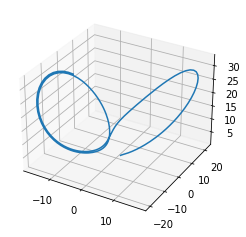

In [43]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(yobs[:, 0].flatten(), yobs[:, 1].flatten(), yobs[:, 2].flatten())
plt.draw()
plt.show()

In [32]:
# now we provide parameters, that assimilation will start from
xb = [1., 1., 1.] + [20., 10., 5.]
xb = np.array(xb).reshape(-1, 1)
error_vector = [0.1, 0.1, 0.1, 100, 100, 100] # diagonal of covariance matrix of each parameter

And now we run 4D-Var data assimilation on generated observations

In [33]:
result = assimilate(xb, yobs, lorenz_obs_operator, lorenz_evol_step, error_vector=error_vector, verbose=True)

  Intermediate CurrentState at the current iteration: [ 1.  1.  1. 20. 10.  5.]
Calibration of 6 coefficients on 20 measures
---------------------------------------------------------------------
Calibration resulting coefficients.: [ 1.  1.  1. 20. 10.  5.]


In [34]:
# generate observations from assimilated parameters
res = np.array(prepare_obs(np.array(result).reshape(-1, 1), lorenz_obs_operator, lorenz_evol_step, 200))

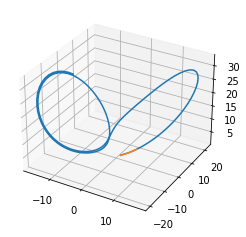

In [35]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(res[:, 0].flatten(), res[:, 1].flatten(), res[:, 2].flatten())
ax.plot(yobs[:, 0].flatten(), yobs[:, 1].flatten(), yobs[:, 2].flatten())
plt.draw()
plt.show()

### SEIR epidemic model

We will try to generate data based on SEIR model and then based on these observations we will use 4D-Var data assimilation to fit parameters.

In our case observations is total number of deaths to given day.

**TASK 5** write observation operator for Lorenz63 model (Hint: state is an array \[s, e, i, r, d, alpha, beta, eps, gamma\])

In [96]:
def seir_obs_operator(state):
    D = seir_step(state)
    return D

In [97]:
# TODO define some random parameters to generate observations
params = [ 0.008, 3, 0.04, 0.04 ]
seird = [40000000, 1, 0, 0, 0]
state = np.array(seird + params).reshape(-1, 1)
days = 200

In [98]:
# generate observations based on prepared earlier parameters
yobs = prepare_obs(state, seir_obs_operator, seir_step, size=days)

In [99]:
# now we try to find parameters that will result in matching observations
result = assimilate(seird + [0.01, 0.5, 0.5, 0.5], yobs, seir_obs_operator, seir_step, verbose=True)

  Intermediate CurrentState at the current iteration: [4.e+07 1.e+00 0.e+00 0.e+00 0.e+00 1.e-02 5.e-01 5.e-01 5.e-01]
  Intermediate CurrentState at the current iteration: [ 4.00000000e+07  1.01810829e+00  1.82843873e-02  2.61552386e-04
  5.23119871e-05 -5.66347988e-01  1.08929065e+00  5.12537641e-01
 -6.54554048e-02]
  Intermediate CurrentState at the current iteration: [ 4.00000000e+07  1.00410848e+00  4.14843915e-03  5.93421117e-05
  1.18687649e-05 -1.20764270e-01  6.33700754e-01  5.02844593e-01
  3.71707086e-01]
  Intermediate CurrentState at the current iteration: [ 4.00000000e+07  1.00757063e+00  7.64425164e-03  1.09348605e-04
  2.18703523e-05 -2.30956887e-01  7.46367893e-01  5.05241678e-01
  2.63597034e-01]
  Intermediate CurrentState at the current iteration: [ 4.00000000e+07  1.00763762e+00  7.71189531e-03  1.10316227e-04
  2.20638822e-05 -2.33089105e-01  7.48547992e-01  5.05288062e-01
  2.61505113e-01]
  Intermediate CurrentState at the current iteration: [ 4.00000000e+07  1

In [102]:
# generate new observations based on result from data assimilation
res = prepare_obs(result, seir_obs_operator, seir_step, size=200)

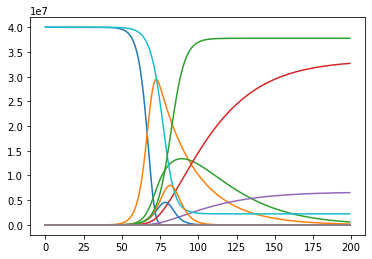

In [101]:
plt.plot(range(days), [x.flatten () for x in yobs])
plt.plot(range(days), [x.flatten () for x in res])

### Assimilation of actual data

Here we try to fir parameters to the actual data concerning COVID-19

In [104]:
# data can be found in file `covid-deaths.csv` 
from data_assimilation import load_data
yobs = load_data(size = 100, country = 'POL')

In [105]:
seird = [36000000, 30000, 10000, 80000, 2349]
result = assimilate(seird + [0.01, 0.1, 0.1, 0.1], yobs, seir_obs_operator, seir_step, verbose=True)

  Intermediate CurrentState at the current iteration: [3.600e+07 3.000e+04 1.000e+04 8.000e+04 2.349e+03 1.000e-02 1.000e-01
 1.000e-01 1.000e-01]
  Intermediate CurrentState at the current iteration: [ 3.60000000e+07  3.00000000e+04  1.00000000e+04  8.00000000e+04
  2.34900000e+03 -4.91267102e-01  7.90683239e-01  2.34465775e-01
 -4.03593995e-01]
  Intermediate CurrentState at the current iteration: [ 3.60000000e+07  3.00000000e+04  1.00000000e+04  8.00000000e+04
  2.34900000e+03 -5.81534476e-01  8.55139095e-01 -8.36652862e-02
 -4.94280392e-01]
  Intermediate CurrentState at the current iteration: [ 3.60000000e+07  3.00000000e+04  1.00000000e+04  8.00000000e+04
  2.34900000e+03 -5.02486249e-01  7.98694325e-01  1.94925915e-01
 -4.14865222e-01]
  Intermediate CurrentState at the current iteration: [ 3.60000000e+07  3.00000000e+04  1.00000000e+04  8.00000000e+04
  2.34900000e+03 -5.12713482e-01  8.05997131e-01  1.58881879e-01
 -4.25139930e-01]
  Intermediate CurrentState at the current it

In [106]:
res = prepare_obs(result, seir_obs_operator, seir_step)

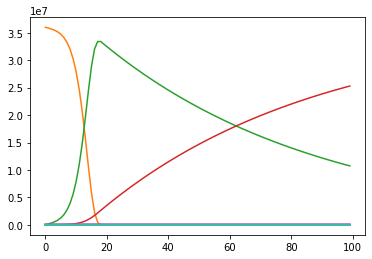

In [73]:
plt.plot(range(100), yobs)
plt.plot(range(100), res)

# lab 7

# Introduction to Lorenz and SEIR models

![Lorenz equations](images/lorenz.png)

source: https://en.wikipedia.org/wiki/Lorenz_system

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

In [54]:
def lorenz_step(coords, t, parameters):
    rho, sigma, beta = parameters
    x, y, z = coords
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

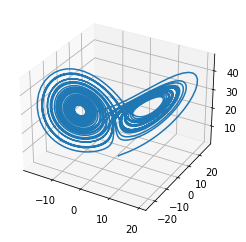

In [165]:
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

x = 1
y = 1
z = 1

start_coords = [x, y, z]
parameters = [rho, sigma, beta]

t = np.arange(0.0, 40.0, 0.01)

states_gt = odeint(lorenz_step, start_coords, t, args=(parameters,))

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states_gt[:, 0], states_gt[:, 1], states_gt[:, 2])
plt.draw()
plt.show()

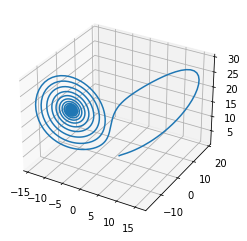

In [166]:
sigma = 13.25
rho = 19.0
beta = 3.5

x = 1
y = 1
z = 1

start_coords = [x, y, z]
parameters = [rho, sigma, beta]

t = np.arange(0.0, 40.0, 0.01)

states_1 = odeint(lorenz_step, start_coords, t, args=(parameters,))

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states_1[:, 0], states_1[:, 1], states_1[:, 2])
plt.draw()
plt.show()

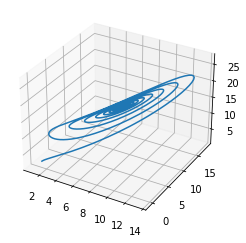

In [167]:
sigma = 7.0
rho = 18.0
beta = 3.7

x = 1
y = 1
z = 1

start_coords = [x, y, z]
parameters = [rho, sigma, beta]

t = np.arange(0.0, 40.0, 0.01)

states_2 = odeint(lorenz_step, start_coords, t, args=(parameters,))

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states_2[:, 0], states_2[:, 1], states_2[:, 2])
plt.draw()
plt.show()

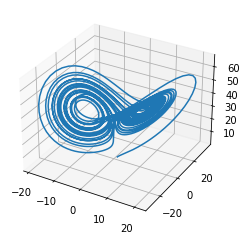

In [168]:
sigma = 6.5
rho = 38.0
beta = 1.7

x = 1
y = 1
z = 1

start_coords = [x, y, z]
parameters = [rho, sigma, beta]

t = np.arange(0.0, 40.0, 0.01)

states_3 = odeint(lorenz_step, start_coords, t, args=(parameters,))

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states_3[:, 0], states_3[:, 1], states_3[:, 2])
plt.draw()
plt.show()

In [173]:
mean_model = calc_mean_lorenz(np.array([states_1, states_2, states_3]))

In [176]:
mean_model

array([[1.        , 1.        , 1.        ],
       [1.0092229 , 1.2297395 , 0.98183669],
       [1.03588314, 1.46198571, 0.96681744]])

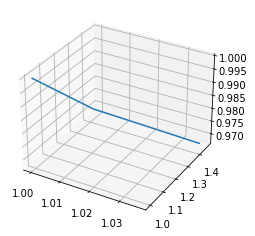

In [175]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(mean_model[:, 0], mean_model[:, 1], mean_model[:, 2])
plt.draw()
plt.show()

In [195]:
def calc_mean_lorenz(lorenz_models):
    return np.array([np.mean(lorenz_models[:,i,:], axis=0) for i in range(3)])

def calc_weighted_average_lorenz(lorenz_models, weights):
    return np.array([np.average(lorenz_models[:,i,:], axis=0, weights=weights) for i in range(3)])


In [196]:
calc_mean_lorenz(test_models)

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [197]:
calc_weighted_average_lorenz(test_models, [1,1,1])

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [186]:
test_models = np.array([
    [[1,2,3],[4,5,6],[7,8,9]],
    [[1,2,3],[4,5,6],[7,8,9]],
    [[1,2,3],[4,5,6],[7,8,9]]
])

In [125]:
np.array([np.average(a[:,i,:], axis=0, weih) for i in range(3)])

array([[1.33333333, 2.        , 3.        ],
       [4.        , 5.        , 6.        ],
       [7.        , 8.        , 9.        ]])

In [121]:
calc_mean_lorenz(np.array([states_1[:,-0, states_2, states_3]))

array([4., 5., 6.])

In [182]:
states_1[:,0][:3]

array([1.        , 1.01077127, 1.04140143])

In [181]:
states_1

array([[ 1.        ,  1.        ,  1.        ],
       [ 1.01077127,  1.16992538,  0.9763124 ],
       [ 1.04140143,  1.34213566,  0.95538539],
       ...,
       [-7.9372524 , -7.93725186, 17.99999948],
       [-7.93725234, -7.93725192, 17.99999922],
       [-7.9372523 , -7.93725199, 17.99999898]])